In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

# Stair function
The function $\nu$ should often look like:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < tau_0 \\
\nu_1,\; \tau_0 < \tau < tau_1 \\
...\\
\nu_i,\; \tau_{i-1} < \tau < \tau_i\\
...\\
\nu_{k+1},\; \tau > tau_k
\end{cases}
$$
And we are going to work with this case.

In [2]:
def stair_function(x, borders=[], values=[0]):
    """
    Parameters:
    -----------
    x : float or float array
        The argument of the function
    
    borders : list of floats len N
        The points, when the function changes the value
    
    values: list of floats len N+1
        values[0] corresponds to the function value before borders[0]
        values[i] corresponds to the function value between borders[i-1] and borders[i]
        
    Returns:
    --------
    r : float or float array shape x.shape
    """
    x = np.array(x)
    r = values[0]*np.ones(x.shape)
    for i in range(len(borders)):
        r[x >= borders[i]] = values[i+1]
    return r

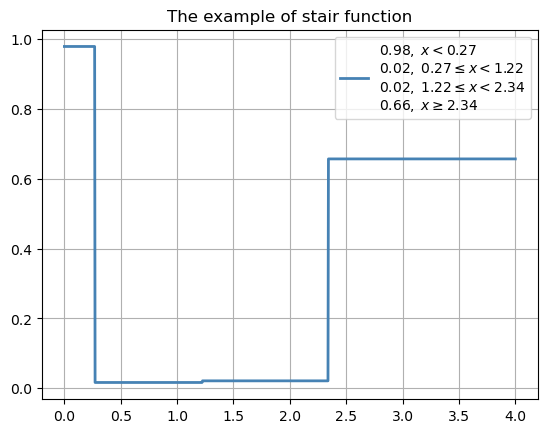

In [3]:
x0, x1 = 0, 4
n_stairs = 3
borders = x0 + (x1 - x0)*np.sort(np.random.random(n_stairs))
values = np.random.random(n_stairs + 1)

label = [r'${0:.2f}, \; {1:.2f} \leq x < {2:.2f}$'.format(values[i+1], 
                                                          borders[i], 
                                                          borders[i+1]) for i in range(n_stairs - 1)]
label = np.append(r'${0:.2f}, \; x < {1:.2f}$'.format(values[0], borders[0]), label)
label = np.append(label, r'${0:.2f}, \; x \geq {1:.2f}$'.format(values[-1], borders[-1]))
label = '\n'.join(label)

x = np.linspace(x0, x1, 1000)
y = stair_function(x, borders=borders, values=values)

plt.title('The example of stair function')
plt.plot(x, y, color='steelblue', linewidth=2, label=label)
plt.legend()
plt.grid(True)
plt.show()

# Equations for the elevations
For the moment $\tau > \tau_i$, $\tau < \tau_{i+1}$ and
$$
\chi = n(\tau - \tau_i)\nu(\tau_i)^{(n-1)/n}
$$
the elevation:
$$
\lambda = (n-1)(\tau - \tau_i)\nu(\tau_i) + \int\limits_{\tau_i}^\tau \nu(\tau\prime) d\tau\prime
$$

## Understanding this formula
This should be an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau, \chi)
$$
where $\nu(\tau, \chi) = \nu(\tau)$ is a stair finction of $\tau$ and do not depend on $\chi$:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i \in \{1, ..., k\}\\
\nu_{k + 1},\; \tau > \tau_k
\end{cases}
$$

The equations like this have the [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3302.pdf) like
$$
\lambda(\tau, \chi) = c_1\chi - \nu(c_1)\tau + \int\limits_0^\tau \nu(t) dt + c_2
$$

We have a border constrain $\lambda(\tau, 0) = 0$, so we can conclude:
1. $\lambda(0, 0) = c_2 = 0$
2. $\lambda(\tau, 0) = -\nu(c_1) + \int\limits_0^\tau \nu(t) dt$
$$
\nu(c_1)\tau = \int\limits_0^\tau \nu(t) dt
$$
taking the derivative
$$
\nu(c_1) = \nu(\tau)
$$
and
$$
c_1 = \nu^{-1}(\nu(\tau))
$$
$c_1$ should be a conatsant, but $\nu$ is uninversible stair function, so let's define $\nu^{-1}(\nu(\tau))$ as
$$
\nu^{-1}(\nu(\tau)) = \nu_i:\; i\; \text{s.t.}\; \min_{\tau_i > \tau} \tau_i
$$

In [31]:
class RiverProfile:
    def __init__(self, 
                 initial=lambda chi: 0*chi, 
                 boundary=lambda tau: 0*tau, 
                 nu_borders=[], 
                 nu_values=[1], 
                 n=1
                ):
        """
        Parameters:
        -----------
        initial: function
            lambda(0, chi)
            
        boundary: function
            lambda(tau, 0)
        
        nu_borders : float list len N
            The points, when the nu function changes the value
        
        values: list of floats len N+1
            values[0] corresponds to the function value before borders[0]
            values[i] corresponds to the function value between borders[i-1] and borders[i]
        """
        
        self.initial = initial
        self.boundary = boundary
        if len(nu_borders) != len(nu_values) - 1:
            raise ValueError(f'Wrong list lengths:\nlen(nu_borders) - len(nu_values) = {len(nu_borders) - len(nu_values)}, but should be 1.')
        self.nu_borders = list(nu_borders)
        self.nu_values = list(nu_values)
        self.nu = lambda tau, chi: stair_function(tau, borders=self.nu_borders, values=self.nu_values)
        self.n = n
        
        
    def get_patches(self, tau):
        # 
        tau_l = np.array(tau)
        tau_l[tau_l < self.nu_borders[0]] = np.nan
        for i in range(len(self.nu_borders)):
            tau_l[tau_l >= self.nu_borders[i]] = self.nu_borders[i]
        tau_r = np.array(tau) - tau_l
        chi = self.n*tau_r*self.nu(tau, 0)**((self.n - 1)/self.n)
        lam = self.n*tau_r*self.nu(tau, 0)
        return chi, lam

In [32]:
rp = RiverProfile(nu_borders=[0, 1, 2], nu_values=[1, 2, 1, 2])

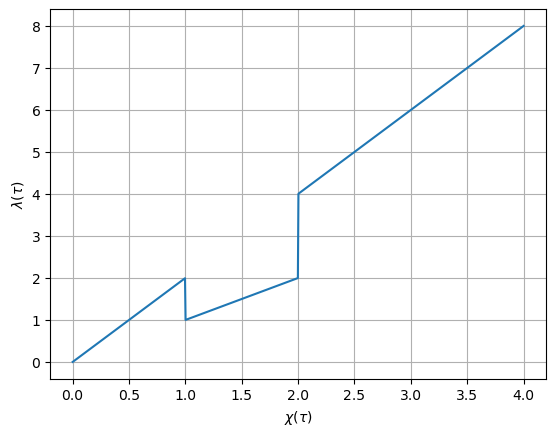

In [39]:
chi, lam = rp.get_patches(np.linspace(-1, 4, 1000))

plt.plot(chi, lam)

plt.xlabel(r'$\chi(\tau)$')
plt.ylabel(r'$\lambda(\tau)$')

plt.grid(True)
plt.show()